# Setup

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: rich_clust
python version: 3.9.12


In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import natsort

import torch
# from kymatio.torch import Scattering2D

import gc
import time
import functools
import multiprocessing as mp


In [3]:
tic = time.time()
toc = {}
toc['start'] = time.time() - tic

In [4]:
dir_save = '/home/rich/Desktop/'

In [9]:
params = {
    'paths': {
        'dir_github': r'/media/rich/Home_Linux_partition/github_repos/',  ## directory where ROICat is
        'dir_allOuterFolders': r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/20220117_email/Proximal_Dendrites",  ## directory where directories containing below 'pathSuffixTo...' are
        'pathSuffixToStat': 'stat.npy',  ## path suffix to where the stat.npy file is
        'pathSuffixToOps': 'ops.npy',  ## path suffix to where the ops.npy file is
        'dir_save': r'/home/rich/Desktop/',  ## default: None. Directory to save output file to. If None then saves in dir_allOuterFolders.
        'filenamePrefix_save': None,  ##  default: None. Filename prefix to save results to. If None then just uses the dir_allOuterFolders.name.
    },
    'importing': {
        'data_verbose': True,  ## default: True. Whether to print out data importing information
        'out_height_width': [72, 72],  ## default: [36,36]. Height and width of small cropped output images of each ROI. Check how large your ROIs are in pixels.
        'max_footprint_width': 1025,  ## default: 1025. Maximum length of a spatial footprint. If you get an error during importing, try increasing this value.
        'type_meanImg': 'meanImgE',  ## default: 'meanImgE'. Type of mean image to use for normalization. This is just a field in the ops.npy file.
        'um_per_pixel': 1.0,  ## default: 1.0. Number of microns per pixel for the imaging dataset. Doesn't need to be exact. Used for resizing the ROIs. Check the images of the resized ROIs to tweak.
        'new_or_old_suite2p': 'new',  ## default: 'new'. If using suite2p, this specifices whether the stat.npy file is in the old MATLAB format or new Python format.
        'images': None,  ## default: None. Set to None if you want to use the images extracted from Suite2p
        'import_workers': -1, ## default: -1. Number of workers to use for importing. Set to -1 to use all available workers.
    },
    'alignment': {
        'session_template': 0.5,  ## default: 0.5. Which session to use as a registration template. If input is float (ie 0.0, 0.5, 1.0, etc.), then it is the fractional position of the session to use; if input is int (ie 1, 2, 3), then it is the index of the session to use (0-indexed)
        'phaseCorr': {
            'freq_highPass': 0.01,  ## default: 0.01. Spatial frequency upper-bound cut-off to use for phase correlation. Units in fraction of the height of the FOV. Spatial frequencies correlations higher than this will be set to zero.
            'freq_lowPass': 0.3,  ## default: 0.3. Spatial frequency lower-bound cut-off to use for phase correlation. Units in fraction of the height of the FOV. Spatial frequencies correlations lower than this will be set to zero.
        },
        'method': 'createOptFlow_DeepFlow',  ## default: 'createOptFlow_DeepFlow'. Method to use for creating optical flow.
        'kwargs_method': None,  ## default: None. Keyword arguments to pass to the cv2 optical flow method.
        'use_CLAHE': False,  ## default: False. Whether or not to use 'Contrast Limited Adaptive Histogram Equalization'. Useful if params['importing']['type_meanImg'] is not a contrast enhanced image (like 'meanImgE' in Suite2p)
        'return_sparse': True,  ## default: True. Whether to return a sparse matrix (True) or a dense matrix (False).
        'normalize': True,  ## default: True. If True, normalize the spatial footprints to have a sum of 1.
    },
    'blurring': {
        'kernel_halfWidth': 5.0,  ## default: 2.0. Half-width of the cosine kernel used for blurring. Set value based on how much you think the ROIs move from session to session.
        'plot_kernel': False,  ## default: False. Whether to plot the kernel used for blurring.
    },
    'ROInet': {
        'device': 'cuda:0',  ## default: 'cuda:0'. Device to use for ROInet. Recommend using a GPU.
        'hash_dict_true': {
            'params': ('params.json', '68cf1bd47130f9b6d4f9913f86f0ccaa'),
            'model': ('model.py', '61c85529b7aa33e0dfadb31ee253a7e1'),
            'state_dict': ('ConvNext_tiny__1_0_best__simCLR.pth', '3287e001ff28d07ada2ae70aa7d0a4da'),
        },
        'dir_networkFiles': '/home/rich/Downloads/ROInet',  ## local directory where network files are stored
        'download_from_gDrive': 'check_local_first',  ## default: 'check_local_first'. Whether to download the network files from Google Drive or to use the local files.
        'gDriveID': '1D2Qa-YUNX176Q-wgboGflW0K6un7KYeN',  ## default: '1FCcPZUuOR7xG-hdO6Ei6mx8YnKysVsa8'. Google Drive ID of the network files.
        'forward_pass_version': 'latent', # default: 'latent'. Leave as 'latent' for most things. Can be 'latent' (full pass through network), 'head' (output of the head layers), or 'base' (pass through just base layers)
        'verbose': True,  ## default: True. Whether to print out ROInet information.
        'pref_plot': False,  ## default: False. Whether to plot the ROI and the normalized ROI.
        'batchSize_dataloader': 8,  ## default: 8. Number of images to use for each batch.
        'pinMemory_dataloader': True,  ## default: True. Whether to pin the memory of the dataloader.
        'persistentWorkers_dataloader': True,  ## default: True. Whether to use persistent workers for the dataloader.
        'prefetchFactor_dataloader': 2,  ## default: 2. Number of prefetch factors to use for the dataloader.
    },
    'SWT': {
        'kwargs_Scattering2D': {'J': 2, 'L': 2},  ## default: {'J': 2, 'L': 8}. Keyword arguments to pass to the Scattering2D function.
        'device': 'cuda:0',  ## default: 'cuda:0'. Device to use for SWT. Recommend using a GPU.
    }, 
    'similarity': {
        'spatialFootprint_maskPower': 0.8,  ## default: 1.0. This determines the power to take the ROI mask images to. Higher for more dependent on brightness, lower for more dependent on binary overlap.
        'n_workers': -1,  ## default: -1. Number of workers to use for similarity. Set to -1 to use all available workers.
        'block_height': 128,  ## default: 64. Maximum height of the FOV block bins to use for pairwise ROI similarity calculations. Use smaller values (16-64) if n_sessions is large (<12), else keep around (64-128)
        'block_width': 128,  ## default: 64. Maximum width of the FOV block bins to use for pairwise ROI similarity calculations. Use smaller values (16-64) if n_sessions is large (<12), else keep around (64-128)
        'algorithm_nearestNeigbors_spatialFootprints': 'brute',  ## default: 'brute'. Algorithm to use for nearest neighbors.
        'verbose': True,  ## default: True. Whether to print out similarity information.
        'normalization': {
            'k_max': 4000,  ## default: 4000. Maximum kNN distance to use for building a distribution of pairwise similarities for each ROI.
            'k_min': 150,  ## default: 150. Set around n_sessions*10. Minimum kNN distance to use for building a distribution of pairwise similarities for each ROI. 
            'algo_NN': 'kd_tree',
            'device': 'cuda:0', 
        },
    },
    ## Cluster
    'clustering': {
        'plot_pref': True,
        'auto_pruning':{
            'n_bins': 50,  ## default: 50. Number of bins to use for estimating the distributions for 'different' and 'same' pairwise similarities
            'find_parameters_automatically': True, 
            'n_jobs': -1,
            'kwargs_findParameters': {
                'n_patience': 100,
                'tol_frac': 0.05,
                'max_trials': 350,
                'max_duration': 60*10,
                'verbose': False,
            },
            'bounds_findParameters': {
                'power_SF': (0.3, 2),
                'power_NN': (0.2, 2),
                'power_SWT': (0.1, 1),
                'p_norm': (-5, 5),
                'sig_NN_kwargs_mu': (0, 0.5),
                'sig_NN_kwargs_b': (0.05, 2),
                'sig_SWT_kwargs_mu': (0, 0.5),
                'sig_SWT_kwargs_b': (0.05, 2),
            },
        },
        'method': 'auto',  ## default: 'auto'. Can be 'hungarian', 'hdbscan', or 'auto'. If 'auto', then if n_sessions >=8 'hdbscan' will be used.
        'hdbscan':{  ## Used only if 'method' is 'hdbscan'
            'min_cluster_size': 2,
            'alpha': 0.85,  ## default: 0.999. Use slightly smaller values (~0.8) if you want bigger less conservative clusters. See hdbscan documentation: https://hdbscan.readthedocs.io/en/latest/parameter_selection.html
            'd_clusterMerge': None,  ## default: None. Distance (mixed conjunctive distance) at which all samples less than this far apart are joined in clusters. If None, then set to mean + 1.0 std of the distribution. See 'cluster_selection_epsilon' in hdbscan documentation: https://hdbscan.readthedocs.io/en/latest/parameter_selection.html
            'cluster_selection_method': 'leaf',  ## default: 'leaf'. 'leaf' is better for smaller homogeneous clusters, 'eom' is better for larger clusters of various densities. See hdbscan documentation: https://hdbscan.readthedocs.io/en/latest/parameter_selection.html
            'split_intraSession_clusters': True,  ## default: True. Splits up clusters with multiple ROIs from the same session into multiple clusters.
            'd_step': 0.03,  ## default: 0.03. Size of steps to take when splitting clusters with multiple ROIs from the same session. Smaller values give higher quality clusters.
            'discard_failed_pruning': True,  ## default: Failsafe. If the splitting doesn't work for whatever reason, then just set all violating clusters to label=-1.
            'n_iter_violationCorrection': 5,  ## default: 5. Number of times to iterate a correcting process to improve clusters. Warning: This can increase run time linearly for large datasets. Typically converges after around 5 iterations. If n_sessions is large (>30), consider increasing.
        },
        'hungarian': {
            'thresh_cost': 0.95, ## default: 0.95. Threshold distance at which all clusters larger than this are discarded. Note that typically no change will occur after values > d_cutoff.
        },
        'kwargs_makeConjunctiveDistanceMatrix': {
            'power_SF': 1.0,
            'power_NN': 1.0,
            'power_SWT': 0.1,
            'p_norm': -2,
            'sig_SF_kwargs': None,
            'sig_NN_kwargs':  {'mu':0, 'b':0.2},
            'sig_SWT_kwargs': {'mu':0, 'b':0.2},
        },
    },
}

In [10]:
dir_github = Path(params['paths']['dir_github']).resolve()

import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from ROICaT.tracking import data_importing, visualization, alignment, blurring, helpers, ROInet, scatteringWaveletTransformer, similarity_graph, clustering

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
params_all = [params]

['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']
['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/20220117_email/Proximal_Dendrites/D1
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/20220117_email/Proximal_Dendrites/D2
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/20220117_email/Proximal_Dendrites/D3
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/20220117_email/Proximal_Dendrites/D4
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/20220117_email/Proximal_Dendrites/D5
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/20220117_email/Proximal_Dendrites/D6
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/20220117_email/Proximal_Dendrites/D7
/media/rich/bigSSD/other lab data/Ha

14it [00:01, 12.46it/s]


Converted 14 spatial footprint files into small centered images in self.ROI_images.
Imported 14 FOV images into class as self.FOV_images
Importing spatial footprints from stat files.
Imported 14 sessions of spatial footprints into sparse arrays.


100%|███████████████████████████████████████████| 14/14 [02:03<00:00,  8.84s/it]


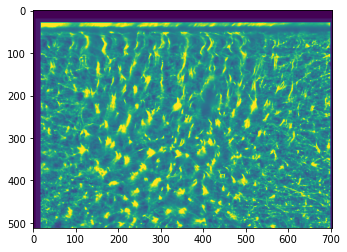

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

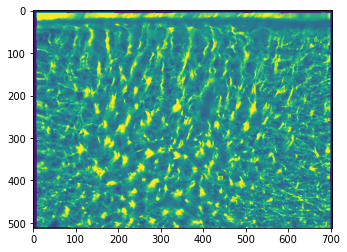

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

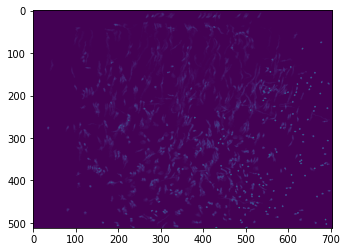

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

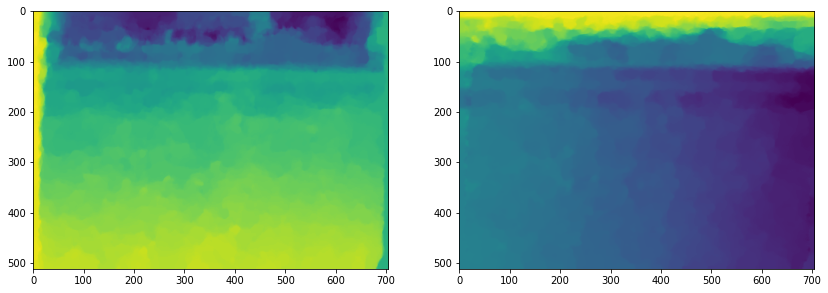

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

Preparing the Toeplitz convolution matrix
Performing convolution for blurring
Successful hash comparison. Found matching files: {'params': '/home/rich/Downloads/ROInet/params.json', 'model': '/home/rich/Downloads/ROInet/model.py', 'state_dict': '/home/rich/Downloads/ROInet/ConvNext_tiny__1_0_best__simCLR.pth'}
Imported model from /home/rich/Downloads/ROInet/model.py
Loaded params_model from /home/rich/Downloads/ROInet/params.json


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /home/rich/Downloads/ROInet/ConvNext_tiny__1_0_best__simCLR.pth
Loaded network onto device cuda:0
Starting: resizing ROIs


100%|███████████████████████████████████████████| 14/14 [00:06<00:00,  2.27it/s]


Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader
starting: running data through network


  0%|                                                  | 0/2857 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node 

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile informati

completed: running data through network
SWT initialized
Starting: SWT transform on ROIs


  0%|                                                | 0/228.55 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/tqdm/std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|█████████████████████████████████████| 229/228.55 [00:00<00:00, 301.66it/s]


Completed: SWT transform on ROIs
Computing pairwise similarity between ROIs...


100%|███████████████████████████████████████████| 24/24 [00:39<00:00,  1.63s/it]


Joining blocks into full similarity matrices...
Joining s_sf...


24it [00:00, 186.90it/s]


Joining s_NN...


24it [00:00, 69.64it/s]


Joining s_SWT...


24it [00:00, 69.26it/s]


Joining s_sesh...


24it [00:00, 62.22it/s]


Finding k-range of center of mass distance neighbors for each ROI...
Normalizing Neural Network similarity scores...


100%|██████████████████████████████████| 22855/22855 [00:01<00:00, 13469.36it/s]


Normalizing SWT similarity scores...


100%|███████████████████████████████████| 22855/22855 [00:05<00:00, 4263.51it/s]


Finding mixing parameters using automated hyperparameter tuning...
Best value found: 0.047016341239213943 with parameters {'power_SF': 1.6904284990034635, 'power_NN': 0.2766953190408838, 'power_SWT': 0.874680169576492, 'p_norm': -2.1876454031648644, 'sig_SF_kwargs': None, 'sig_NN_kwargs': {'mu': 0.2734716581163969, 'b': 1.4455059834348134}, 'sig_SWT_kwargs': {'mu': 0.4793610967065667, 'b': 0.201819708217724}}
Fitting with HDBSCAN and splitting clusters with multiple ROIs per session


  0%|                                                     | 0/5 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|█████████████████████████████████████████████| 5/5 [01:29<00:00, 17.96s/it]


<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [12]:
for params in params_all:
    # %matplotlib notebook


    # Import paths
    def print_list(l):
        for item in l:
            print(item)

    dir_allOuterFolders = Path(params['paths']['dir_allOuterFolders']).resolve()

    folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])

    folders_toUse = folders_allSessions
    # folders_toUse = list(map(folders_allSessions.__getitem__, [np.arange(1,9, dtype=np.int32)]))


    # dir_allS2pFolders = [dir_allOuterFolders / folder / 'exp' / 'suite2p' / 'plane0' for folder in folders_toUse]
    dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_toUse]

    pathSuffixToStat = params['paths']['pathSuffixToStat']
    pathSuffixToOps = params['paths']['pathSuffixToOps']

    paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
    paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]

    print(folders_allSessions)
    print(folders_toUse)
    print_list(dir_allS2pFolders)
    print_list(paths_allStat)

    toc['import_paths'] = time.time() - tic


    #Import data
    data = data_importing.Data_suite2p(
        paths_statFiles=paths_allStat,
        paths_opsFiles=paths_allOps,
        um_per_pixel=params['importing']['um_per_pixel'],    
        new_or_old_suite2p=params['importing']['new_or_old_suite2p'],
        verbose=params['importing']['data_verbose'],
    );

    data.import_statFiles();

    data.import_ROI_centeredImages(
        out_height_width=params['importing']['out_height_width'],
        max_footprint_width=params['importing']['max_footprint_width'],
    );

    data.import_FOV_images(
        type_meanImg=params['importing']['type_meanImg'],
        images=params['importing']['images'],
    );

    data.import_ROI_spatialFootprints(workers=params['importing']['import_workers']);

    # visualization.display_toggle_image_stack(data.FOV_images)

    toc['import_data'] = time.time() - tic


    # Alignment
    FOV_images = [alignment.clahe(im, grid_size=10, clipLimit=0, normalize=True) for im in pcr.ims_registered[:]] if params['alignment']['use_CLAHE'] else data.FOV_images
    st = params['alignment']['session_template']
    idx_st = int(st * data.n_sessions) if type(st) is float else st


    pcr = alignment.PhaseCorrelation_registration()

    pcr.set_spectral_mask(
        freq_highPass=params['alignment']['phaseCorr']['freq_highPass'],
        freq_lowPass=params['alignment']['phaseCorr']['freq_lowPass'],
        im_shape=(data.FOV_height, data.FOV_width)
    )

    pcr.register(
        im_template=FOV_images[idx_st],
        ims_moving=FOV_images
    );

    aligner = alignment.Alinger(
        method=params['alignment']['method'],
        kwargs_method=params['alignment']['kwargs_method'],
    )

    aligner.register_ROIs(
        templateFOV=pcr.ims_registered[idx_st],
        FOVs=pcr.ims_registered,
        ROIs=data.spatialFootprints,
        shifts=pcr.shifts,
        return_sparse=params['alignment']['return_sparse'],
        normalize=params['alignment']['normalize'],
    );


    visualization.display_toggle_image_stack(pcr.ims_registered[:])

    visualization.display_toggle_image_stack(aligner.FOVs_aligned)
    visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection(), clim=[0,0.03])
    visualization.display_toggle_2channel_image_stack(aligner.flows)

    toc['alignment'] = time.time() - tic


    # Blur ROIs (optional)
    blurrer = blurring.ROI_Blurrer(
        frame_shape=(data.FOV_height, data.FOV_width),
        kernel_halfWidth=params['blurring']['kernel_halfWidth'],
        plot_kernel=params['blurring']['plot_kernel'],
    )

    blurrer.blur_ROIs(
        spatialFootprints=aligner.ROIs_aligned,
    )

    # visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

    toc['blur'] = time.time() - tic


    # Neural network embedding distances
    roinet = ROInet.ROInet_embedder(
        device=params['ROInet']['device'],
        dir_networkFiles=params['ROInet']['dir_networkFiles'],
        download_from_gDrive=params['ROInet']['download_from_gDrive'],
        gDriveID=params['ROInet']['gDriveID'],
        hash_dict_networkFiles=params['ROInet']['hash_dict_true'],
        verbose=params['ROInet']['verbose'],
    )

    roinet.generate_dataloader(
        ROI_images=data.ROI_images,
        um_per_pixel=params['importing']['um_per_pixel'],
        pref_plot=params['ROInet']['pref_plot'],
        batchSize_dataloader=params['ROInet']['batchSize_dataloader'],
        pinMemory_dataloader=params['ROInet']['pinMemory_dataloader'],
        numWorkers_dataloader=mp.cpu_count(),
        persistentWorkers_dataloader=params['ROInet']['persistentWorkers_dataloader'],
        prefetchFactor_dataloader=params['ROInet']['prefetchFactor_dataloader'],    
    );

    # visualization.display_toggle_image_stack(roinet.ROI_images_rs)

    roinet.generate_latents();

    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

    toc['NN'] = time.time() - tic


    # Scattering wavelet embedding distances
    swt = scatteringWaveletTransformer.SWT(
        kwargs_Scattering2D=params['SWT']['kwargs_Scattering2D'], 
        image_shape=params['importing']['out_height_width'], 
        device=params['SWT']['device'],
    )

    swt.transform(ROI_images=np.concatenate(data.ROI_images, axis=0));

    toc['SWT'] = time.time() - tic


    # Compute similarities
    # sim = similarity_graph.ROI_graph(
    #     n_workers=params['similarity']['n_workers'],
    #     frame_height=data.FOV_height,
    #     frame_width=data.FOV_width,
    #     block_height=params['similarity']['block_height'],
    #     block_width=params['similarity']['block_width'],
    #     algorithm_nearestNeigbors_spatialFootprints=params['similarity']['algorithm_nearestNeigbors_spatialFootprints'],
    #     verbose=params['similarity']['verbose'],
    # )
    sim = similarity_graph.ROI_graph(
        n_workers=params['similarity']['n_workers'],
        frame_height=data.FOV_height,
        frame_width=data.FOV_width,
        block_height=128,
        block_width=128,
        algorithm_nearestNeigbors_spatialFootprints=params['similarity']['algorithm_nearestNeigbors_spatialFootprints'],
        verbose=params['similarity']['verbose'],
    )

    sim.visualize_blocks()

    sim.compute_similarity_blockwise(
        spatialFootprints=blurrer.ROIs_blurred,
        features_NN=roinet.latents,
        features_SWT=swt.latents,
        ROI_session_bool=data.sessionID_concat,
        spatialFootprint_maskPower=params['similarity']['spatialFootprint_maskPower'],
    );

    sim.make_normalized_similarities(
        centers_of_mass=data.get_midCoords(),
        features_NN=roinet.latents,
        features_SWT=swt.latents,
        k_max=params['similarity']['normalization']['k_max'],
        k_min=params['similarity']['normalization']['k_min'],
        algo_NN=params['similarity']['normalization']['algo_NN'],
        device=params['similarity']['normalization']['device'],
    )

    toc['sim'] = time.time() - tic

    ## Cluster
    clusterer = clustering.Clusterer(
        s_sf=sim.s_sf,
        s_NN_z=sim.s_NN_z,
        s_SWT_z=sim.s_SWT_z,
        s_sesh=sim.s_sesh,
    )

    kwargs_makeConjunctiveDistanceMatrix_best = clusterer.find_optimal_parameters_for_pruning(
        n_bins=params['clustering']['auto_pruning']['n_bins'],
        find_parameters_automatically=params['clustering']['auto_pruning']['find_parameters_automatically'],
        kwargs_findParameters=params['clustering']['auto_pruning']['kwargs_findParameters'],
        bounds_findParameters=params['clustering']['auto_pruning']['bounds_findParameters'],
        n_jobs_findParameters=params['clustering']['auto_pruning']['n_jobs'],
    #     fallback_d_cutoff=0.5,
    #     plot_pref=True,
    )

    toc['separate_diffSame'] = time.time() - tic

    if params['clustering']['plot_pref']:
        clusterer.plot_distSame()

        clusterer.plot_similarity_relationships(
            plots_to_show=[1,2,3], 
            max_samples=100000, 
            kwargs_scatter={'s':1, 'alpha':0.2},
            kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
        );

    clusterer.make_pruned_similarity_graphs(
        kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best
    )

    if params['clustering']['method']=='hungarian' or ((params['clustering']['method']=='auto') and (data.n_sessions<8)):
        labels = clusterer.fit_sequentialHungarian(
            session_bool=data.sessionID_concat,
            thresh_cost=params['clustering']['hungarian']['thresh_cost'],
            d_conj=None,
#             kwargs_makeConjunctiveDistanceMatrix={
#             'power_SF': 1.0,
#             'power_NN': 1.0,
#             'power_SWT': 0.1,
#             'p_norm': -2,
#             'sig_SF_kwargs': None,
#             'sig_NN_kwargs':  {'mu':0, 'b':0.2},
#             'sig_SWT_kwargs': {'mu':0, 'b':0.2},
#             },
        )
    else:
        labels = clusterer.fit(
            session_bool=data.sessionID_concat,
            min_cluster_size=params['clustering']['hdbscan']['min_cluster_size'],
            cluster_selection_method=params['clustering']['hdbscan']['cluster_selection_method'],
            d_clusterMerge=params['clustering']['hdbscan']['d_clusterMerge'],
            alpha=params['clustering']['hdbscan']['alpha'],
            n_iter_violationCorrection=params['clustering']['hdbscan']['n_iter_violationCorrection'],
            d_conj=None,
            kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
            split_intraSession_clusters=params['clustering']['hdbscan']['split_intraSession_clusters'],
            d_step=params['clustering']['hdbscan']['d_step'],
            discard_failed_pruning=params['clustering']['hdbscan']['discard_failed_pruning'],
        )

    labels_bySession = [labels[idx] for idx in data.sessionID_concat.T]

    toc['clustering'] = time.time() - tic

    # visualization
    FOV_clusters = visualization.compute_colored_FOV(
        boolSessionID=data.sessionID_concat,
        spatialFootprints=aligner.ROIs_aligned,
        FOV_height=data.FOV_height,
        FOV_width=data.FOV_width,
        labels=labels,
        confidence=None,
    #     threshold_confidence = 0.99,
    )

    %matplotlib notebook
    visualization.display_toggle_image_stack(FOV_clusters)

    toc['visualize'] = time.time() - tic


    ## Save results
    dir_save = Path(params['paths']['dir_allOuterFolders']).resolve() if params['paths']['dir_save'] is None else Path(params['paths']['dir_save']).resolve()
    filenamePrefix_save = dir_allOuterFolders.name if params['paths']['filenamePrefix_save'] is None else params['paths']['filenamePrefix_save']
    path_save = dir_save / (filenamePrefix_save + '.ROICaT.results' + '.pkl')

    ROIs = {
        "ROIs_aligned": aligner.ROIs_aligned,
        "ROIs_raw": data.spatialFootprints,
        "frame_height": data.FOV_height,
        "frame_width": data.FOV_width,
        "idx_roi_session": np.where(data.sessionID_concat)[1]
    }

    results = {
        "UCIDs": labels,
        "UCIDs_bySession": labels_bySession,
        "ROIs": ROIs,
        "params": params,
        "runTimes": toc,
    }

    helpers.simple_save(
        obj=results,
        filename=path_save,
        mkdir=True,
    )
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

    toc['saving'] = time.time() - tic

In [13]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [14]:
print(toc)

{'start': 4.601478576660156e-05, 'import_paths': 46.32927083969116, 'import_data': 60.045172929763794, 'alignment': 185.69902300834656, 'blur': 188.4225332736969, 'NN': 264.5528144836426, 'SWT': 265.63998770713806, 'sim': 350.50216245651245, 'separate_diffSame': 359.5527868270874, 'clustering': 456.00429034233093, 'visualize': 457.1045243740082, 'saving': 457.64132046699524}


In [34]:
labels = clusterer.fit_sequentialHungarian(
    session_bool=data.sessionID_concat,
    thresh_cost=params['clustering']['hungarian']['thresh_cost'],
    d_conj=None,
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
#             kwargs_makeConjunctiveDistanceMatrix={
#             'power_SF': 1.0,
#             'power_NN': 1.0,
#             'power_SWT': 0.1,
#             'p_norm': -2,
#             'sig_SF_kwargs': None,
#             'sig_NN_kwargs':  {'mu':0, 'b':0.2},
#             'sig_SWT_kwargs': {'mu':0, 'b':0.2},
#             },
)


Clustering with CaImAn's iterative Hungarian algorithm method...


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  7.56it/s]


In [67]:
labels = clusterer.fit(
    session_bool=data.sessionID_concat,
    min_cluster_size=2,
    cluster_selection_method='leaf',
    d_clusterMerge=None,
    alpha=0.85,
    n_iter_violationCorrection=15,
    d_conj=None,
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
    split_intraSession_clusters=True,
    d_step=0.005,
    discard_failed_pruning=params['clustering']['hdbscan']['discard_failed_pruning'],
)

Fitting with HDBSCAN and splitting clusters with multiple ROIs per session


100%|███████████████████████████████████████████| 15/15 [05:27<00:00, 21.86s/it]


In [68]:
display(np.array(labels[:]))

array([ 133,  193, 2891,  192,  125,  194,  114,  123,  191,  190, 3099,
        134,  170, 2999, 2888, 2090,  117,  187, 1244,  157, 1575, 3101,
        131, 3007, 2892, 3084, 3098, 2875,  129,  308, 2970,  121,  188,
       2968, 2882, 2994, 2890,  132, 3090,  135, 3097,  119, 3091, 3077,
        124, 2855, 1246,  186,  126, 2886,  156, 3086, 3443, 3080,  151,
       3006,  116, 1234, 3062,  946, 3075, 2879, 3078, 3072,  189,  122,
       3094, 3401, 3093, 2878, 2974, 3004, 1258,  145, 3323, 2996, 2881,
       2877,  136, 3076,  846, 2889, 3048,  154, 2977, 1630, 2885, 2876,
       3202,  985,  153,  137,  115, 3036, 2989, 3071, 1813, 3066, 3363,
       3087, 1123,  120, 3446,  155, 3060,  138, 3050, 1560, 3452, 1227,
       2987, 3056, 2983, 3054, 3083, 3317, 2975, 2976, 3089, 3472, 1624,
       1281, 3002, 3055,  128, 1262, 1276, 3058, 3306, 2884, 3367, 1257,
        118, 3000,  147, 1242,  144, 3039, 3044,  717, 3096,  150, 3059,
       3095,  263,  974,  981,  967,  945, 1650, 30

In [31]:
np.set_printoptions(threshold=sys.maxsize)

In [69]:
labels_bySession = [labels[idx] for idx in data.sessionID_concat.T]

toc['clustering'] = time.time() - tic

# visualization
FOV_clusters = visualization.compute_colored_FOV(
    boolSessionID=data.sessionID_concat,
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    labels=labels,
    confidence=None,
#     threshold_confidence = 0.99,
)

%matplotlib notebook
visualization.display_toggle_image_stack(FOV_clusters)

toc['visualize'] = time.time() - tic


## Save results
dir_save = Path(params['paths']['dir_allOuterFolders']).resolve() if params['paths']['dir_save'] is None else Path(params['paths']['dir_save']).resolve()
filenamePrefix_save = dir_allOuterFolders.name if params['paths']['filenamePrefix_save'] is None else params['paths']['filenamePrefix_save']
path_save = dir_save / (filenamePrefix_save + '.ROICaT.results' + '.pkl')

ROIs = {
    "ROIs_aligned": aligner.ROIs_aligned,
    "ROIs_raw": data.spatialFootprints,
    "frame_height": data.FOV_height,
    "frame_width": data.FOV_width,
    "idx_roi_session": np.where(data.sessionID_concat)[1]
}

results = {
    "UCIDs": labels,
    "UCIDs_bySession": labels_bySession,
    "ROIs": ROIs,
    "params": params,
    "runTimes": toc,
}

helpers.simple_save(
    obj=results,
    filename=path_save,
    mkdir=True,
)
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

toc['saving'] = time.time() - tic

<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [12]:
# if params['clustering']['plot_pref']:
#     clusterer.plot_distSame()

#     clusterer.plot_similarity_relationships(
#         plots_to_show=[1,2,3], 
#         max_samples=100000, 
#         kwargs_scatter={'s':1, 'alpha':0.2},
#         kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
#     );


In [13]:
# import numpy as np
# import scipy.sparse

# import torch_sparse as ts

# scipy.sparse.save_npz(
#     file=r'/home/rich/Desktop/c_sim.npz',
#     matrix=sim.c_sim.tocsr(),
#     compressed=True
# )
# scipy.sparse.save_npz(
#     file=r'/home/rich/Desktop/cluster_bool.npz',
#     matrix=sim.cluster_bool.tocsr(),
#     compressed=True
# )
# np.save(
#     file=r'/home/rich/Desktop/scores.npy',
#     arr=sim.scores.numpy(),
# )

# c_sim = scipy.sparse.load_npz(file=r'/home/rich/Desktop/c_sim.npz').tolil()
# cluster_bool = scipy.sparse.load_npz(file=r'/home/rich/Desktop/cluster_bool.npz').tocsr()
# scores = torch.as_tensor(np.load(file=r'/home/rich/Desktop/scores.npy'), dtype=torch.float32)